In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

if os.getcwd().split("\\")[-1] == "homework":
    os.chdir("../")
    
import cmds.custom_portfolio_management_helper as cpm
# import cmds.portfolio_management_helper as pm

Hidden latex commands

$$\newcommand{\iidsim}{\stackrel{\text{i.i.d.}}{\sim}}$$

# Homework \#6 

Case: AQR's Momentum Funds (A) [9-211-025].

## 1 The Momentum Product

This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

## 1.1
What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

The used offered it in the form of a mutual fund. Before it was typically only through hedge funds


## 1.2
Name three reasons the momentum investment product will not exactly track the momentum index, (ie. why the strategy will have tracking error.)

- Different rebalance frequency
- Taxes
- AQR might exclude stocks that they thought were going to go bad (based on other factors besides momentum)



## 1.3
When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?

A paper by Jegadeesh (1990) showed evidence that stocks with high returns last month tend to reverse in the following month.


# 2 Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, "momentum_data.xlsx".

- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\text {mom }}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
    - $r^{\text {mom(1) }}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
    - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
    - $r^{\text {momSU }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
    - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by FF as,

$$
\begin{equation*}
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right) \tag{1}
\end{equation*}
$$


In [3]:
file_path = r"data/momentum_data.xlsx" 
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

# display(dfs_raw['descriptions'].head())
annual_factor = 12

ticker_mapping = {tick: name 
                  for tick, name in zip(dfs_raw['descriptions'].iloc[:, 0], 
                                                dfs_raw['descriptions'].iloc[:, 1])}

ticker_mapping


descriptions: (8, 5)
factors (excess returns): (1173, 4)
momentum (excess returns): (1173, 2)
deciles (total returns): (1173, 11)
size_sorts (total returns): (1173, 7)
risk-free rate: (1173, 2)


{'MKT': 'Market',
 'SMB': 'Size',
 'HML': 'Value',
 'RF': 'Risk-free rate',
 'SMALL LoPRIOR': 'Small Down',
 'SMALL HiPRIOR': 'Small Up',
 'BIG LoPRIOR': 'Big Down',
 'BIG HiPRIOR': 'Big Up'}

In [4]:
df_total_returns = (dfs_raw["deciles (total returns)"].set_index("Date")
                    .rename(columns={"Lo PRIOR": "mom(1)",
                                    "PRIOR 2": "mom(2)",
                                    "PRIOR 3": "mom(3)",
                                    "PRIOR 4": "mom(4)",
                                    "PRIOR 5": "mom(5)",
                                    "PRIOR 6": "mom(6)",
                                    "PRIOR 7": "mom(7)",
                                    "PRIOR 8": "mom(8)",
                                    "PRIOR 9": "mom(9)",
                                    "Hi PRIOR": "mom(10)",})
                    .merge(dfs_raw["size_sorts (total returns)"].set_index("Date"),
                           how="outer",
                           left_index=True,
                           right_index=True)
                    .rename(columns={"SMALL LoPRIOR": "momSD",
                                    "SMALL HiPRIOR": "momSU",
                                    "BIG LoPRIOR": "momBD",
                                    "BIG HiPRIOR": "momBU"
                                    })
                    )
# print(df_total_returns.isna().sum())
display(df_total_returns.head())


,mom(1),mom(2),mom(3),mom(4),mom(5),mom(6),mom(7),mom(8),mom(9),mom(10),momSD,ME1 PRIOR2,momSU,momBD,ME2 PRIOR2,momBU
Date,,,,,,,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718


In [5]:
df_excess_returns = (dfs_raw["momentum (excess returns)"].set_index("Date")
                    .rename(columns={"UMD": "mom:FF"})
                    .merge(dfs_raw["factors (excess returns)"].set_index("Date"),
                           how="outer",
                           left_index=True,
                           right_index=True)
                    .rename(columns={"MKT": "m",
                                    "SMB": "s",
                                    "HML": "v"})
                    )
# print(df_excess_returns.isna().sum())
display(df_excess_returns.head())


,mom:FF,m,s,v
Date,,,,
1927-01-31,0.0036,-0.0006,-0.0037,0.0454
1927-02-28,-0.0214,0.0418,0.0004,0.0294
1927-03-31,0.0361,0.0013,-0.0165,-0.0261
1927-04-30,0.0430,0.0046,0.0030,0.0081
1927-05-31,0.0300,0.0544,0.0153,0.0473


In [6]:
df_risk_free = (dfs_raw["risk-free rate"]
                .set_index("Date")
                .rename(columns={"RF": "f"})
                )

df_risk_free.head()

,f
Date,
1927-01-31,0.0025
1927-02-28,0.0026
1927-03-31,0.0030
1927-04-30,0.0025
1927-05-31,0.0030



## 2.1. Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.
### 2.1.a Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

#### Table 1: Momentum performance over time.

| Subsample | mean | vol | Sharpe | skewness | corr. to $\tilde{r}^{m}$ | corr. to $\tilde{r}^{v}$ |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |

1927-2024
1927-1993
1994-2008
2009-2024


In [7]:
def homework_6_summary_table(df, annual_factor=12, summary_cols=["mean", "vol", "sharpe", "skewness"]):
    summary_cols = ["mean", "vol", "sharpe", "skewness"]
    
    df_table = cpm.calc_summary_stats(df, 
                                      annual_factor=annual_factor,
                                      summary_cols = summary_cols
                                      ).T


    # corr. to $\tilde{r}^{m}$ | corr. to $\tilde{r}^{v}$
    df_table["corr to m"] = df.corrwith(df_excess_returns["m"], axis=0)
    df_table["corr to v"] = df.corrwith(df_excess_returns["v"], axis=0)
    return df_table


masks = {"full": df_excess_returns.index,
         "1927:1993":(df_excess_returns.index.year >= 1927) & (df_excess_returns.index.year < 1993),
         "1994:2008":(df_excess_returns.index.year >= 1994) & (df_excess_returns.index.year < 2008),
         "2009:2024":(df_excess_returns.index.year >= 2009),
}

df_temp = pd.DataFrame()
for sample_name, sample_mask in masks.items():
    df_temp[sample_name] = df_excess_returns.loc[sample_mask, "mom:FF"]

df_table1 = homework_6_summary_table(df_temp)
display(df_table1)

,mean,vol,sharpe,skewness,corr to m,corr to v
full,0.075328,0.162508,0.463534,-2.990493,-0.344284,-0.406410
1927:1993,0.088274,0.160707,0.549287,-3.805803,-0.364777,-0.504255
1994:2008,0.097950,0.172699,0.567171,-0.685658,-0.200952,-0.075988
2009:2024,-0.015092,0.158467,-0.095238,-2.691022,-0.367588,-0.320924



### 2.1.b Has momentum changed much over time, as seen through these subsample statistics?


The momentum strategies seems to have significantly declined past 2009

### 2.1.c 

Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs-would there still be evidence here that momentum is valuable?

todo

Hard to say. Decent negative correlation with market and value. If the actual mean returns were near 0, then it wouldn't be a good investment?


## 2.2 
The case is about whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation: ${ }^{1}$,

$$
\tilde{r}^{\mathrm{momU}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-r^{f}
$$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$
\tilde{r}^{\operatorname{momU}}=\frac{1}{3}\left(r^{\operatorname{mom}(8)}+r^{\operatorname{mom}(9)}+r^{\operatorname{mom}(10)}\right)-r^{f}
$$

For the question below, use the FF-style, $\tilde{r}_{t}^{\text {momU:FF }}$.



In [8]:
df_excess_returns["momU:FF"] = 1/2 * (
    df_total_returns["momBU"] + df_total_returns["momSU"]
) - df_risk_free["f"]


### 2.2.a 
Fill out Table 2 for the data in the period 1994-2024.

#### Table 2: Long-only momentum performance.

| $1994-2024$ | mean | vol | Sharpe | skew | corr. to $\tilde{r}^{m}$ | corr. to $\tilde{r}^{v}$ |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |

Long-and-short, ( $\tilde{r}^{\text {mom:FF }}$ )
Long-only ( $\tilde{r}^{\mathrm{momU}: \mathrm{FF}}$ )

In [9]:
masks["1994:"] = (df_excess_returns.index.year >= 1994)

df_temp = df_excess_returns.loc[masks["1994:"], ["mom:FF", "momU:FF"]]
df_table2 = homework_6_summary_table(df_temp)
display(df_table2)

,mean,vol,sharpe,skewness,corr to m,corr to v
mom:FF,0.043184,0.167682,0.257534,-1.445951,-0.306180,-0.215225
momU:FF,0.117195,0.178410,0.656885,-0.444802,0.903581,-0.118954



### 2.2.b 
Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

Yes, it actually seems more attractive, when only considering these statistics.



### 2.2.c 
Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?


No, the correlations are alot higher for both momentum and value


### 2.2.d 
Show a plot of the cumulative product of $1+\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$ and $1+\tilde{r}^{\mathrm{momU}: \mathrm{FF}}$ over the 1994-2024 subsample. ${ }^{2}$


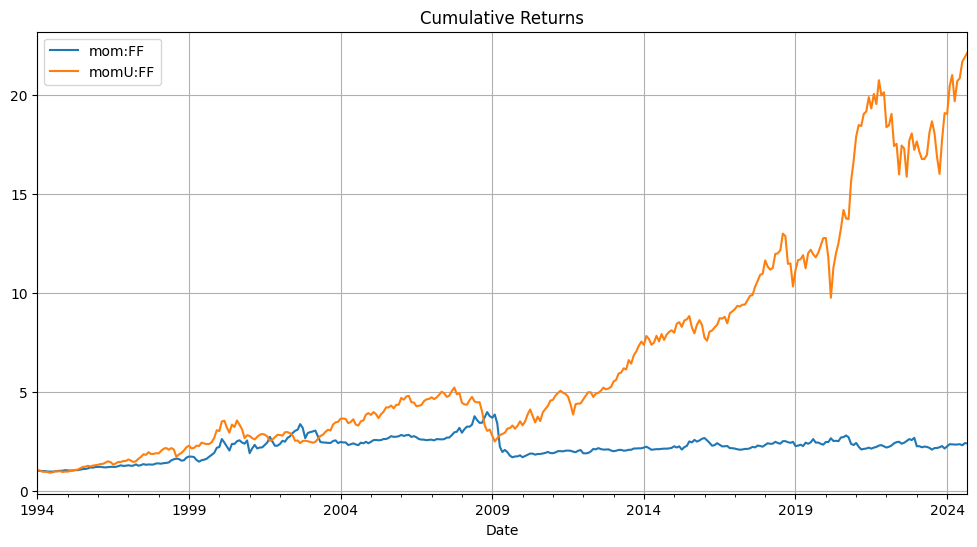

In [10]:
df_temp = df_excess_returns.loc[masks["1994:"],["mom:FF", "momU:FF"]]
df_temp = (df_temp + 1).cumprod()

df_temp.plot(figsize=(12, 6), title="Cumulative Returns")
plt.grid()


## 2.3 Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the "winners" and "losers" is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles

$$
\tilde{r}^{\mathrm{momD1}}=r^{\operatorname{mom}(10)}-r^{\operatorname{mom}(1)}
$$

- long the top 3 deciles and short the bottom 3 deciles

$$
\begin{aligned}
\tilde{r}^{\operatorname{momD3}} & =\frac{1}{3}\left(r^{\operatorname{mom}(8)}+r^{\operatorname{mom}(9)}+r^{\operatorname{mom}(10)}\right)-\frac{1}{3}\left(r^{\operatorname{mom}(1)}+r^{\operatorname{mom}(2)}+r^{\operatorname{mom}(3)}\right) \\
& =\frac{1}{3} \sum_{k=8}^{10} r^{\operatorname{mom}(k)}-\frac{1}{3} \sum_{k=1}^{3} r^{\operatorname{mom}(k)}
\end{aligned}
$$

- long the top 5 deciles and short the bottom 5 deciles

$$
\tilde{r}^{\operatorname{momD} 5}=\frac{1}{5} \sum_{k=6}^{10} r^{\operatorname{mom}(k)}-\frac{1}{5} \sum_{k=1}^{5} r^{\operatorname{mom}(k)}
$$



### 2.3.a 
Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2024.


#### Table 3: Robustness of momentum construction.

| 1994-2024 | mean | vol | Sharpe | skewness | corr. to $\tilde{r}^{m}$ | corr. to $\tilde{r}^{v}$ |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| $\tilde{r}^{\text {momD1 }}$ |  |  |  |  |  |  |
| $\tilde{r}^{\text {momD3 }}$ |  |  |  |  |  |  |
| $\tilde{r}^{\text {momD5 }}$ |  |  |  |  |  |  |
|  |  |  |  |  |  |  |


In [11]:
def decile_portfolio(df_total_returns, df_risk_free, num_deciles, short_bottom=True, excess=False):
    vals = -1 * df_risk_free["f"]
    if not excess:
        vals = vals * 0
    for i in range(1, num_deciles+1):
        vals += df_total_returns[f"mom({11-i})"] * (1/num_deciles)
        
        if short_bottom:
            vals -= df_total_returns[f"mom({i})"] * (1/num_deciles)
    
    return vals
    
    
for n in [1,3,5]:
    df_excess_returns[f"momD{n}"] = decile_portfolio(df_total_returns, df_risk_free, n)

In [12]:
df_temp = df_excess_returns.loc[masks["1994:"], ["momD1", "momD3", "momD5"]]

df_table3 = homework_6_summary_table(df_temp)
display(df_table3)

,mean,vol,sharpe,skewness,corr to m,corr to v
momD1,0.082010,0.299035,0.274248,-1.304629,-0.319715,-0.233463
momD3,0.028551,0.193383,0.147638,-1.345002,-0.361659,-0.211472
momD5,0.016411,0.133990,0.122480,-1.415925,-0.348584,-0.212234




### 2.3.b
Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?


Yes, the D1 portfolio has a higher mean, sharpe, and vol compared to the D5 portfolio.


### 2.3.c 
Should AQR's retail product consider using a 1-decile or 5-decile construction?


1-decile looks alot better, it has higher mean and better sharpe.


### 2.3.d
Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3 -decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [13]:
pd.concat([df_table2.loc["mom:FF"], df_table3.loc["momD3"]],axis=1).T

,mean,vol,sharpe,skewness,corr to m,corr to v
mom:FF,0.043184,0.167682,0.257534,-1.445951,-0.306180,-0.215225
momD3,0.028551,0.193383,0.147638,-1.345002,-0.361659,-0.211472


The fama-french construction looks to be a lot better just based on the mean and sharpe.


## 2.4 Does implementing momentum require trading lots of small stocks-thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)
Use the data provided on both small-stock "winners", $r^{\text {momSU }}$, and small-stock "losers", $r^{\text {momSD }}$, to construct a small-stock momentum portfolio,

$$
r_{t}^{\operatorname{mom} S}=r_{t}^{\mathrm{momSU}}-r_{t}^{\mathrm{momSD}}
$$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$
r_{t}^{\operatorname{mom} B}=r_{t}^{\mathrm{momBU}}-r_{t}^{\mathrm{momBD}}
$$


In [14]:
df_total_returns["momS"] = df_total_returns["momSU"] - df_total_returns["momSD"]
df_total_returns["momB"] = df_total_returns["momBU"] - df_total_returns["momBD"]


### 2.4.a 
Fill out Table 4 over the sample 1994-2024.

#### Table 4: Momentum of small and big stocks.

| 1994-2024 | mean | vol | Sharpe | skewness | corr. to $\tilde{r}[m]$ |
| :--- | :--- | :--- | :--- | :--- | :--- |

All stocks, $\tilde{r}^{\text {mom:FF }}$
Small stocks $r_{t}^{\text {mom } S}$
Large stocks $r_{t}^{\text {mom } B}$



In [15]:
df_temp = (df_excess_returns.loc[masks["1994:"], ["mom:FF"]]
           .merge(df_total_returns.loc[masks["1994:"], ["momS", "momB"]],
                  how="outer",
                  left_index=True,
                  right_index=True)
)

df_table4 = homework_6_summary_table(df_temp)
display(df_table4)

,mean,vol,sharpe,skewness,corr to m,corr to v
mom:FF,0.043184,0.167682,0.257534,-1.445951,-0.306180,-0.215225
momS,0.063200,0.169633,0.372569,-1.763649,-0.303976,-0.148512
momB,0.023177,0.182458,0.127028,-0.879114,-0.280159,-0.257523



### 2.4.b 
Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?


No. The vol of all these portfolios is about the same, but momS has noticably higher mean return.

## 2.5 
In conclusion, what is your assessment of the $A Q R$ retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?



In [16]:
df_temp = (df_table2
           .rename(index={
               "mom:FF":"FF Construction",
               "momU:FF":"Long Only Construction (AQR Implementation)",
               })
           )

display(df_temp)

,mean,vol,sharpe,skewness,corr to m,corr to v
FF Construction,0.043184,0.167682,0.257534,-1.445951,-0.306180,-0.215225
Long Only Construction (AQR Implementation),0.117195,0.178410,0.656885,-0.444802,0.903581,-0.118954


I do not think AQR accurately captured the appeal of the FF construction, notably it's low correlation to the mark. AQR has a very correlation of .9 to the market. 

It seems shorting the low end is very important in order to replicate the FF construction. They should look to capture these returns while still providing a ETF type investment.


# 3 Barnstable's Analysis


The Risk of Stocks in the Long-Run: The Barnstable College Endowment [HBS 9296073].

This section is not graded, and you do not need to submit your answers.
We may discuss these problems later, but they will not be covered in Midterm 2.

## 3.1. Barnstable's Philosophy
### 3.1.a 
What has Barnstable's investment strategy been in the past?

Just put it all into equities lol


### 3.1.b 
Explain the logic behind their view that stocks are safer in the long run.

They think "sure we might have a few bad years, but in the long return we'll have about the same amount of bad years as we do good years"


### 3.1.c
What assumptions underly Barnstable's belief in the long-run safety of stocks?


They are using a 16% std for annual equity market return which is based on the performance of the stock market after WW2 to 1999.

They used 13% for the mean annual return based on the current (as of 1999) yields of 10Y tresury 6%, plus the historic risk premium seen for the stock market: 7% (timeline unspecified).


## 3.2 Two Proposals
### 3.2.a 
Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

* First option is to sell puts on the S&P with far maturities
* Second option is to take a "tranche* like position in the US equity market. They replicate the S&P 500 and sell preferred shares at a 6% hurdle.


### 3.2.b
How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?


C:\Users\Majes\AppData\Local\Temp\ipykernel_25200\3427005675.py:32: RuntimeWarning: invalid value encountered in power
  final_yield = (final_aum)**(1/maturity_years) - 1
C:\Users\Majes\AppData\Local\Temp\ipykernel_25200\3427005675.py:32: RuntimeWarning: invalid value encountered in power
  final_yield = (final_aum)**(1/maturity_years) - 1
C:\Users\Majes\AppData\Local\Temp\ipykernel_25200\3427005675.py:32: RuntimeWarning: invalid value encountered in power
  final_yield = (final_aum)**(1/maturity_years) - 1
C:\Users\Majes\AppData\Local\Temp\ipykernel_25200\3427005675.py:32: RuntimeWarning: invalid value encountered in power
  final_yield = (final_aum)**(1/maturity_years) - 1


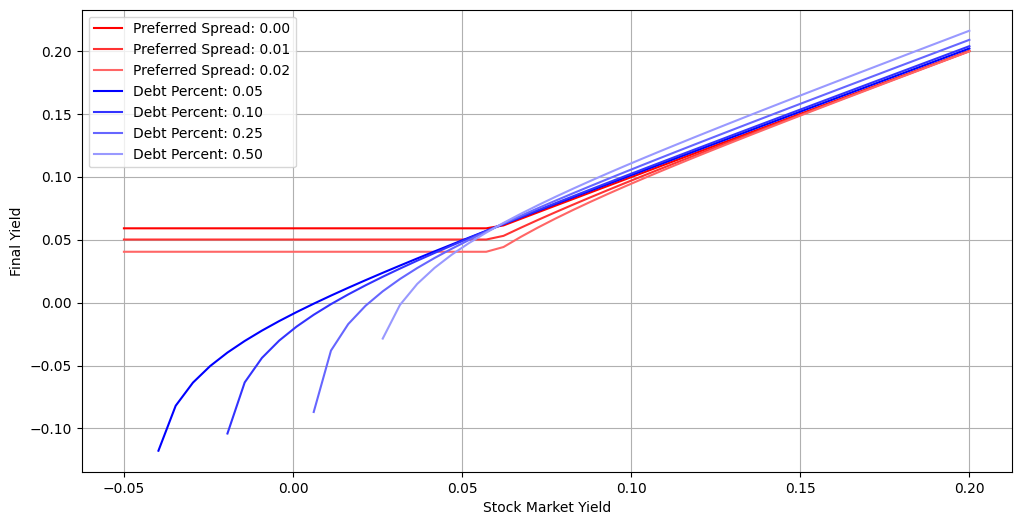

In [17]:
# aum = 1000000
equity_yearly_returns = np.linspace(-.05, .20)
maturity_years = 30
risk_free = .06

def cum_return(rate):
    return (1 + rate) ** maturity_years

def vehicle_yield(equity_yearly_returns, hurdle=.06, preferred_spread=.01, risk_free=.06):
    preferred_cutoff = cum_return(hurdle)
    vehicle_final_val = cum_return(equity_yearly_returns)
    
    final_aum = 0
    
    # Money from Common Stock
    common_stock_final_val = np.maximum(vehicle_final_val - preferred_cutoff, 0)
    
    # Money from selling preferred
    preferred_yield = hurdle + preferred_spread
    preferred_price = preferred_cutoff / (1 + preferred_yield)**maturity_years  # discount
    preferred_final_val = preferred_price * cum_return(risk_free)   # assume invest in risk free

    final_aum = common_stock_final_val + preferred_final_val
    final_yield = (final_aum)**(1/maturity_years) - 1
    return final_yield

def levered_yield(equity_yearly_returns, risk_free=.06, debt_percent=1.5):
    debt = -1 * debt_percent
    equity = 1 - debt
    
    final_aum = equity * cum_return(equity_yearly_returns) + debt * cum_return(risk_free)
    final_yield = (final_aum)**(1/maturity_years) - 1
    return final_yield


debt_percentages = [.05, .10, .25, .5]
preferred_spreads = [.001, .01, .02]
red_shades = ["#FF0000", "#FF3333", "#FF6666", "#FF9999", "#FFCCCC"]
blue_shades = ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#CCCCFF"]

df_temp = pd.DataFrame()

# calculate yield for vehicle portfolio
for preferred_spread in preferred_spreads:
    df_temp[f"vehicle_{preferred_spread*100:.0f}%"] = vehicle_yield(equity_yearly_returns, preferred_spread=preferred_spread)

# calculate yield for levered portfolio
for debt_percent in debt_percentages:
    df_temp[f"levered_{debt_percent*100:.0f}%"] = levered_yield(equity_yearly_returns, debt_percent=debt_percent)

# plot
plt.figure(figsize=(12, 6))
for preferred_spread, color in zip(preferred_spreads, red_shades):
    plt.plot(equity_yearly_returns, df_temp[f"vehicle_{preferred_spread*100:.0f}%"], label=f"Preferred Spread: {preferred_spread:.2f}", color=color)
for debt_percent, color in zip(debt_percentages, blue_shades):
    plt.plot(equity_yearly_returns, df_temp[f"levered_{debt_percent*100:.0f}%"], label=f"Debt Percent: {debt_percent:.2f}", color=color)
plt.xlabel("Stock Market Yield")
plt.ylabel("Final Yield")
plt.legend()
plt.grid()

With a leveraged portfolio you can own more stock and are more sensative to the market performance. 

By selling the perferred stock, you are guaranteed a small amount of money and can invest that in a bond. And you will have a pay off if the market does better then 6%. Its comparable to owning a bond and owning a call option.


### 3.2.c
Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?


No they do not. Take the case where the stock market does very poorly over the 30 years. The puts would be exercised and they would lose a lot of money. In the vehicle case, you still gained some money by selling preferred stock but you didn't make any money on the common stock.


### 3.2.d
Do the two proposals differ in their risk?


The vehicle has holds the upside and protects against the downside, While the puts sell the upside and holds the downside.



### 3.3
Do you recommend a direct investment in the S\&P, the trust or the puts?

Given the trust is for a college, I would suggest a direct investment in the S\&P.


# 4 Estimating Underperformance

This section is required and is to be submitted..
This section is fair game for Midterm 2.

### Data

- Use the returns on the S\&P $500\left(r^{m}\right)$ and 1-month T-bills, $\left(r^{f}\right)$ provided in "barnstable_analysis_data.xlsx".
- Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999.
- We consider this subsample, as well as 2000-2024, as well as the full sample of 1926-2024.
- We only have data through part of 2024, but no adjustment is needed for the fact that you have only the partial year-just use what you have.


In [18]:
file_path = r"data/barnstable_analysis_data.xlsx" 
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")

# display(dfs_raw['descriptions'].head())
annual_factor = 12

ticker_mapping = {tick: name 
                  for tick, name in zip(dfs_raw['descriptions'].iloc[:, 0], 
                                                dfs_raw['descriptions'].iloc[:, 1])}

ticker_mapping


descriptions: (2, 2)
data: (1185, 3)


{'SPX': 'S&P500 Index', 'TB1M': 'Treasury Bill (1M) Index'}

In [37]:
df_level_returns = (dfs_raw["data"]
                    .set_index("date")
                    .rename(columns={
                        "SPX": "m",
                        "TB1M": "f"
                    })
                    .ffill()
                    )
df_level_returns["m_excess"] = df_level_returns["m"] - df_level_returns["f"]
display(df_level_returns.head())

df_log_returns = np.log(1+df_level_returns.copy())
display(df_log_returns.head())

,m,f,m_excess
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033297,0.002612,-0.035909
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


,m,f,m_excess
date,,,
1926-01-30,-0.001785,0.003057,-0.004856
1926-02-27,-0.033864,0.002609,-0.036570
1926-03-31,-0.059440,0.002598,-0.062205
1926-04-30,0.037799,0.002268,0.035610
1926-05-28,0.013531,0.002688,0.010872



## 4.1 Summary Statistics
### 4.1.a 
Report the following (annualized) statistics.

|  |  | 1965-1999 | 2000-2024 | 1926-2024 |
| :---: | :---: | :---: | :---: | :---: |
|  |  | mean/vol | mean/vol | mean/vol |
| levels | $r^{m}$ |  |  |  |
|  | $\tilde{r}^{m}$ |  |  |  |
|  | $r^{f}$ |  |  |  |
| logs | $\mathrm{r}^{m}$ |  |  |  |
|  | $\tilde{\mathrm{r}}^{m}$ |  |  |  |
|  | $\mathrm{r}^{f}$ |  |  |  |


In [21]:
long_data = []
masks = {"1965:1999": (df_level_returns.index.year >= 1965) & (df_level_returns.index.year <= 1999),
         "2000:2024": (df_level_returns.index.year >= 2000),
         "1926:2024": (df_level_returns.index.year >= 1926)
}

for sample_name, sample_mask in masks.items():
    # level data
    df_temp = df_level_returns.loc[sample_mask].copy()
    df_temp = df_temp.melt(value_vars=["m", "m_excess", "f"], 
                           var_name="asset", 
                           value_name="return", 
                           ignore_index=False).reset_index()
    df_temp["sample"] = sample_name
    df_temp["return_type"] = "levels"
    long_data.append(df_temp)
    
    # log data
    df_temp = df_log_returns.loc[sample_mask].copy()
    df_temp = df_temp.melt(value_vars=["m", "m_excess", "f"], 
                           var_name="asset", 
                           value_name="return", 
                           ignore_index=False).reset_index()
    df_temp["sample"] = sample_name
    df_temp["return_type"] = "logs"
    long_data.append(df_temp)

df_temp = pd.concat(long_data).set_index("date")
# display(df_temp)

table4 = (df_temp
          .pivot_table(values="return", 
                       index=["return_type", "asset"], 
                       columns="sample", 
                       aggfunc=["mean", "std"],
                       )
          .rename(columns={"std":"vol"})
          .reindex(["m", "m_excess", "f"], level=1)
          )

# reorder
table4.columns = table4.columns.swaplevel(0, 1)
table4 = table4.sort_index(axis=1)
# Annualize
for c in table4.columns:
    if c[1] == "mean":
        table4[c] = table4[c] * annual_factor
    else:
        table4[c] = table4[c] * np.sqrt(annual_factor)

display(table4)

sample               1926:2024           1965:1999           2000:2024  \
                          mean       vol      mean       vol      mean   
return_type asset                                                        
levels      m         0.115535  0.186777  0.129354  0.149405  0.087283   
            m_excess  0.083340  0.187459  0.068660  0.150227  0.070083   
            f         0.031902  0.008516  0.061503  0.007179  0.017200   
logs        m         0.097804  0.186068  0.117600  0.149568  0.075257   
            m_excess  0.065680  0.187046  0.057161  0.151207  0.058096   
            f         0.031823  0.008482  0.061320  0.007132  0.017173   

sample                          
                           vol  
return_type asset               
levels      m         0.153055  
            m_excess  0.153337  
            f         0.005533  
logs        m         0.154032  
            m_excess  0.154498  
            f         0.005521


### 4.1.b 
Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.



* The difference between log and level returns are similar. 
* In the full sample the returns of the market are a bit higher then recently observed
* The risk free rate was a lot higher in 1965:1999 then in 2000:2024
* the risk premium is about the same across sample


## 4.2 Recall the following...

- If $x \sim \mathcal{N}\left(\mu_{x}, \sigma_{x}^{2}\right)$, then

$$
\begin{aligned}
\operatorname{Pr}[x<\ell] & =\Phi_{\mathcal{N}}(L) \\
L & =\frac{c-\mu_{x}}{\sigma_{x}}
\end{aligned}
$$

where $\Phi_{\mathcal{N}}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns,

$$
\mathrm{r}_{t, t+h}^{m} \equiv \sum_{i=1}^{h} \mathrm{r}_{t+i}^{m}
$$

- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$,

$$
\overline{\mathrm{r}}_{t, t+h}^{m}=\frac{1}{h} \sum_{i=1}^{h} \mathrm{r}_{t+i}^{m}
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return. ${ }^{3}$

$$
\begin{equation*}
\Pr\left[R_{t, t+h}^{m}<R_{t, t+h}^{f}\right] \tag{2}
\end{equation*}
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.


---

We look to find the probability that the cummulative log return on the market $R_{t, t+h}^{m}$ is greater then the cummulative log return on the risk free rate $R_{t, t+h}^{f}$. Note that:
* $R_{t, t+h}^{m} = \sum_{i=1}^{h} r_{t+i}^{m}$
* $R_{t, t+h}^{f} = \sum_{i=1}^{h} r_{t+i}^{f}$

$$\begin{aligned}
\Pr(R_{t, t+h}^{m}<R_{t, t+h}^{f})
    &= \Pr\left(\sum_{i=1}^{h} r_{t+i}^{m}<\sum_{i=1}^{h} r_{t+i}^{f}\right) \\
    &= \Pr\left(\sum_{i=1}^{h} r_{t+i}^{m}- r_{t+i}^{f} < 0\right) \\
\end{aligned}$$


Let $\tilde r_{t}^{m} = r_{t}^{m} - r_{t}^{f}$ be the excess log return of the market. 

$$\begin{aligned}
\Pr(R_{t, t+h}^{m}<R_{t, t+h}^{f})
    &= \Pr\left(\sum_{i=1}^{h} \tilde r_{t+i}^{m} < 0\right) \\
\end{aligned}$$

Let $\tilde r_{t, t+h}^{m} = \sum_{i=1}^{h} \tilde r_{t+i}^{m}$ be the cummulative excess log return of the market.

If we assume $\tilde r_t^m \iidsim \mathcal{N}(\mu, \sigma)$, then $\tilde r_{t, t+h}^{m} \sim \mathcal{N}(h\mu, h\sigma^2)$.

$$\begin{aligned}
\Pr(R_{t, t+h}^{m}<R_{t, t+h}^{f})
    &= \Pr(\tilde r_{t, t+h}^{m} < 0) \\
    &= \Phi_{\mathcal{N}} \left(\frac{0-h\mu}{\sqrt{h}\sigma} \right) \\
    &= \Phi_{\mathcal{N}} \left(-\frac{\sqrt{h}\mu}{\sigma} \right) \\
\end{aligned}$$


### 4.2.a 
Calculate (2) using the subsample 1965-1999.


In [22]:
def probability_of_underperformance(sample_data, h=None):
    mu_hat = sample_data.mean()
    sigma_hat = sample_data.std()
    h = h if h is not None else len(sample_data)
    
    # print(mu_hat)
    # print(sigma_hat)
    
    z_score = -np.sqrt(h) * mu_hat / sigma_hat
    return stats.norm.cdf(z_score)


probability_of_underperformance(df_log_returns.loc[masks["1965:1999"], "m_excess"])

0.01266043954250754


### 4.2.b 
Report the precise probability for $h=15$ and $h=30$ years.


In [23]:
for h_years in [15,30]:
    h = h_years * annual_factor
    prob = probability_of_underperformance(df_log_returns.loc[masks["1965:1999"], "m_excess"], h=h)
    print(f"Probability of underperformance in {h_years} years: {prob:.2%}")

Probability of underperformance in 15 years: 7.16%
Probability of underperformance in 30 years: 1.92%



### 4.2.c 
Plot the probability as a function of the investment horizon, $h$, for $0<h \leq 30$ years.



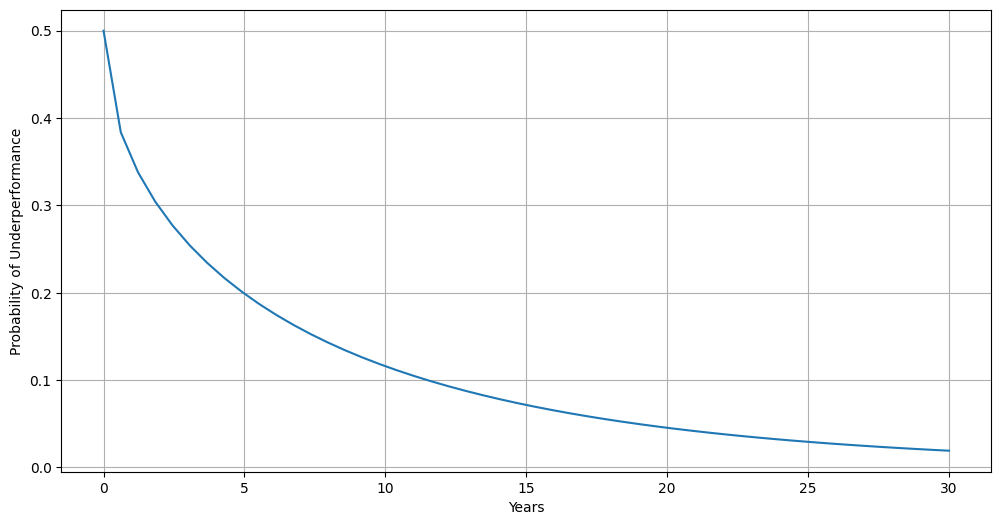

In [24]:
h_year_vals = np.linspace(0, 30)
prob_vals = probability_of_underperformance(df_log_returns.loc[masks["1965:1999"], "m_excess"], h=h_year_vals*annual_factor) 

# Plot
plt.figure(figsize=(12, 6))
plt.plot(h_year_vals, prob_vals)
plt.xlabel("Years")
plt.ylabel("Probability of Underperformance")
plt.grid()
plt.show()



## 4.3 
Use the sample 1965-2024 to reconsider the 30 -year probability. As of the end of 2024, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t, t+h}^{m}$ underperforming $R_{t, t+h}^{f}$ for $0<h \leq 30$.



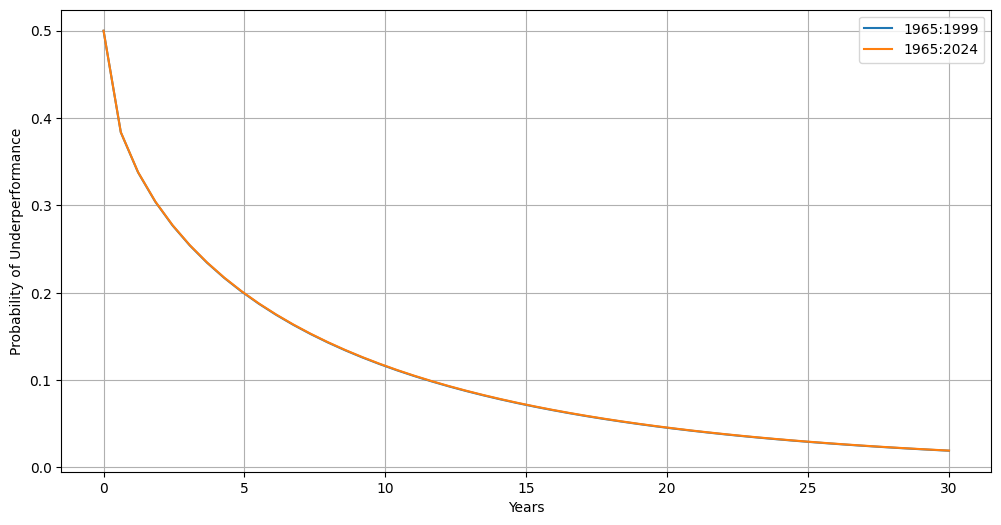

In [25]:
h_year_vals = np.linspace(0, 30)

masks["1965:2024"] = (df_log_returns.index.year >= 1965)

prob_vals_2024 = probability_of_underperformance(df_log_returns.loc[masks["1965:2024"], "m_excess"], h=h_year_vals*annual_factor) 

# Plot
plt.figure(figsize=(12, 6))
plt.plot(h_year_vals, prob_vals, label="1965:1999")
plt.plot(h_year_vals, prob_vals_2024, label="1965:2024")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Probability of Underperformance")
plt.grid()
plt.show()

It looks exactly the same


## 4.4 
Let's consider how things turned out relative to Barnstable's 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$,) that the 25 -year market return, $R_{t, t+25}^{m}$, would be smaller than that realized in 2000-2024? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.


In [26]:
sample_data = df_log_returns.loc[masks["1965:1999"], "m"]

mu_hat = sample_data.mean()
sigma_hat = sample_data.std()
h = 25
target = df_log_returns.loc[masks["2000:2024"], "m"].sum()


z_score = (target-np.sqrt(h)) * mu_hat / sigma_hat
stats.norm.cdf(z_score)

0.23819875860731032